## Micro Domain

The micro domain is defined by a bounding box and a smooth function parameterising the floor of the micro domain. 

In [12]:
import sys
sys.path.append('/home/emastr/phd/')

import torch
from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

In [13]:
class MicroGeom(GaussLegGeometry):
    def __init__(self, func, dfunc, ddfunc, width, height, line_pos, n_refine, n_corner_refine):
        
        dom = np.linspace(0,2*np.pi,5)
        
        # parameterise func 
        f = lambda t: func(t)*1j + width * t / dom[1]
        df = lambda t: dfunc(t)*1j + width / dom[1]
        ddf = lambda t: ddfunc(t)*1j
        
        # Define segments to stitch
        pts = [f(dom[1]), width + height*1j, height*1j, f(dom[0])]
        z, dz, ddz = [f], [df], [ddf]
        
        for i in range(3):
            r, dr, ddr = GaussLegGeometry.get_line_2d(pts[i], pts[i+1], dom[i+1], dom[i+2])
            z.append(r)
            dz.append(dr)
            ddz.append(ddr)
        
        # Stitch segments together
        z = GaussLegGeometry.stitch_functions_1d(z, dom)
        dz = GaussLegGeometry.stitch_functions_1d(dz, dom)
        ddz = GaussLegGeometry.stitch_functions_1d(ddz, dom)
        
        # Define grid
        grid = GaussLegGrid(dom, np.ones((5,)).astype(int))
        grid.refine_all_nply(n_refine)
        grid.refine_corners_nply(n_corner_refine)
        
        # Main properties
        self.width = width
        self.line_pos = line_pos
        super().__init__([z, dz, ddz], grid)
    
    
    def get_inner_pt(self):
        """Overwrite inner_point to be independent of lower boundary."""
        return self.width/2 + self.line_pos * 1j
    
    def precompute_line_avg(self, derivative=0, **kwargs):
        return super().precompute_line_avg(0.05*self.width + self.line_pos * 1j, 0.95*self.width + self.line_pos*1j, derivative, **kwargs)

In [10]:
class GPDomain(MicroGeom):
    def __init__(self, kernel, shape, scale, num, bound=None, X=None, Y=None, K_inv_dy=None, **kwargs):
        
        self.k, self.dk, self.ddk = self.get_kernel(kernel, scale, shape)
        width = kwargs["width"]
        
        if (X is None):
            X, Y, K_inv_dy = self.sample_bounded_gp(self.k, width, bound, num)
            
        r = width / (0.5 * np.pi)
        y = lambda t: K_inv_dy.T @ self.k(r*t, X)
        dy = lambda t: K_inv_dy.T @ self.dk(r*t, X)*r
        ddy = lambda t: K_inv_dy.T @ self.ddk(r*t, X)*r**2
        
        # Data that is used in function methods.
        self.X = X
        self.Y = Y
        
        # Hidden data
        self.kwargs = kwargs
        self.data = {"kernel": kernel,
                     "shape": shape,
                     "scale": scale,
                     "num": num,
                     "Y": Y,
                     "X": X,
                     "K_inv_dy": K_inv_dy}
        super().__init__(y, dy, ddy, **kwargs)
    
    def save(self, path):
        data = self.data.copy()
        data.update(self.kwargs)
        torch.save(data, path)
    
    def plot(self, show_samples=True, show_hline=True, **kwargs):
        super().plot(**kwargs)
        color = kwargs.pop("color", "black")
        ax = kwargs.pop("ax")
        if show_hline:
            ax.plot([0.05*self.width, 0.95*self.width],[self.line_pos, self.line_pos], linewidth=4, color=color)
        if show_samples:
            ax.scatter(self.X, self.Y)
            #plt.scatter(self.X, self.K_inv_df)
    
    @staticmethod
    def load(path, **kwargs):
        if type(path) == str:
            data = torch.load(path)
        elif type(path) == dict:
            data = path
        gp_dom = GPDomain(**data)
        return gp_dom
    
    @staticmethod
    def get_kernel(name, scale, shape):
        if name == "exp":
            # Do smth else
            k = lambda x, y: scale * np.exp(-((x - y) ** 2) / shape)
            dk = lambda x, y: - 2 / shape * (x - y) * k(x, y)
            ddk = lambda x, y: - 2 / shape * (1 - 2 / shape * (x - y)**2) * k(x, y)
        else:
            assert False,f"Kernel {name} not implemented"
        return k, dk, ddk
    
    @staticmethod
    def sample_bounded_gp(k, width, bound, num, resample=0):
            X = np.linspace(-0.1*width, 1.1*width, num)[:,None]#np.sort(np.random.uniform(-0.1*width, 1.1*width, num))[:,None]
            K = k(X, X.T)
            Y = np.random.multivariate_normal(np.zeros_like(X).flatten(), K)[:, None]
            K_inv_dy = np.linalg.solve(K, Y)
            
            #print(K_inv_dy)
            if np.max(np.abs(Y)) >= bound:
                print(f"Resample # {resample}", end="\r")
                return GPDomain.sample_bounded_gp(k, width, bound, num, resample+1)
            else:
                return X, Y, K_inv_dy
            

In [ ]:
np.random.seed(0)
n = 3
plt.figure(figsize=(15,15))
riesz = []
zvec = []
for i in range(n * n):
    
    mg = GPDomain("exp", 
                  shape=.05, 
                  num=20, 
                  scale=.03, 
                  bound=.3, 
                  width=1, 
                  height=1, 
                  line_pos=0.6, 
                  n_refine=1, 
                  n_corner_refine=3)    
    
    r1, func = mg.precompute_line_avg(derivative=0, tol=1e-10, maxiter=40)
    r2, _    = mg.precompute_line_avg(derivative=1, tol=1e-10, maxiter=40)
    mg.data["riesz_vec"]     = r1
    mg.data["riesz_vec_der"] = r2
    z = mg.eval_param()
    
    # To test, plot field corresponding to riesz vector
    v = mg.zero_flow(r1)
    v /= np.linalg.norm(v)
    condition = lambda t: v
    problem = StokesDirichletProblem(mg, condition)
    problem.solve(tol=1e-9, maxiter=40)
    
    ### PLOT ###
    print(f"{i+1}/{n*n} done", end="\r")
    plt.subplot(n,n,i+1) 
    
    vel = lambda z: np.abs(problem.evaluate(z))
    #problem.geometry.plot_field(ax=plt.gca(), func=vel, apply_mask=True, cmap='inferno', vmax=np.max(np.abs(v)))
    #problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
    #plt.quiver(np.real(z), np.imag(z), np.real(r1), np.imag(r1), color="red", scale=5)
    #mg.plot(ax=plt.gca(), show_samples=False, color="white", linewidth=3)  
    
    problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='black', linewidth=1)
    plt.quiver(np.real(z), np.imag(z), np.real(r1), np.imag(r1), color="black", scale=8)
    mg.plot(ax=plt.gca(), show_samples=False, color="black", linewidth=3)  
    
    plt.plot([0,1], [0.3,0.3], "red")
    plt.plot([0,1], [-0.3,-0.3], "red")
    
    #plt.axis("equal")
    plt.xlim([-0.1, 1.1])
    plt.ylim([-1.0, 1.2])
    remove_axes(plt.gca())
    
    riesz.append(r1)
    zvec.append(z)
    
#plt.figure()
#for r in riesz:
#    plt.plot(np.imag(r))

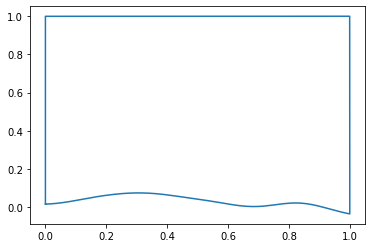

In [5]:
z_mean = np.zeros_like(zvec[0])
for z in zvec:
    z_mean += z / n**2

plt.plot(np.real(z_mean), np.imag(z_mean))

In [7]:
np.random.seed(0)
N = 2000
plt.figure(figsize=(15,15))
riesz = []
zvec = []
for i in range(N):
    print(f"{i+1}/{N} done", end="\n")
    mg = GPDomain("exp", 
                  shape=.05, 
                  num=20, 
                  scale=.03, 
                  bound=.3, 
                  width=1, 
                  height=1, 
                  line_pos=0.6,
                  n_refine=2, 
                  n_corner_refine=4)  
    
    r1, func = mg.precompute_line_avg(derivative=0, tol=1e-12, maxiter=200, verbose=True)
    r2, _    = mg.precompute_line_avg(derivative=1, tol=1e-12, maxiter=200, verbose=True)
    
    vec = np.conjugate(mg.eval_param())
    a = mg.line_pos * 1j + 0.05 * mg.width
    b = mg.line_pos * 1j + 0.95 * mg.width
    print(f"numerical: {func(vec)}, true: {np.real(b**2 - a**2)/2}")
    
    mg.data["riesz_vec"]     = r1
    mg.data["riesz_vec_der"] = r2
    mg.save(f"/home/emastr/phd/data/micro_domains_w_riesz_vectors_3/domain_{i}.GPDomain")
    
    

1/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.450015192872515, true: 0.44999999999999996
2/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449990124321964, true: 0.44999999999999996
3/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999699584267583, true: 0.44999999999999996
4/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999472842709626, true: 0.44999999999999996
5/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500196342708859, true: 0.44999999999999996
6/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000766929360425, true: 0.44999999999999996
7/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997559797930387, true: 0.44999999999999996
8/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499928368526292, true: 0.44999999999999996
9/2000 done
Converged in 0 ite

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998444296835866, true: 0.44999999999999996
69/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999193032332946, true: 0.44999999999999996
70/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45004221120321264, true: 0.44999999999999996
71/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998870139555225, true: 0.44999999999999996
72/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499776683986848, true: 0.44999999999999996
73/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997310087913545, true: 0.44999999999999996
74/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500006070078922, true: 0.44999999999999996
75/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999064340160333, true: 0.44999999999999996
76/2000 done
Converged in 0 ite

Converged in 200 iterations
Converged in 200 iterations
numerical: 0.4499806920216398, true: 0.44999999999999996
136/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500184091721153, true: 0.44999999999999996
137/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499909224952392, true: 0.44999999999999996
138/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999849770510925, true: 0.44999999999999996
139/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998957274426904, true: 0.44999999999999996
140/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44994945814269494, true: 0.44999999999999996
141/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45005163667436976, true: 0.44999999999999996
142/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499734612424689, true: 0.44999999999999996
143/2000 done
Converge

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499568164600282, true: 0.44999999999999996
203/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997575761696823, true: 0.44999999999999996
204/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999161939886895, true: 0.44999999999999996
205/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499726145632516, true: 0.44999999999999996
206/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998482881506646, true: 0.44999999999999996
207/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449973093886848, true: 0.44999999999999996
208/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45006361252915533, true: 0.44999999999999996
209/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499844050716394, true: 0.44999999999999996
210/2000 done
Converged in 

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499860358074297, true: 0.44999999999999996
270/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449985310286274, true: 0.44999999999999996
271/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44995840881669624, true: 0.44999999999999996
272/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4502599071751903, true: 0.44999999999999996
273/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001240457908426, true: 0.44999999999999996
274/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499959084258219, true: 0.44999999999999996
275/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499892914243445, true: 0.44999999999999996
276/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499964902725101, true: 0.44999999999999996
277/2000 done
Converged in 0 

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500472245742409, true: 0.44999999999999996
337/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44996768562230927, true: 0.44999999999999996
338/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.4499507389675531, true: 0.44999999999999996
339/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499921049268841, true: 0.44999999999999996
340/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001249154890555, true: 0.44999999999999996
341/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45002604084623965, true: 0.44999999999999996
342/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998954383805073, true: 0.44999999999999996
343/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500272421287193, true: 0.44999999999999996
344/2000 done
Converge

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449992247226455, true: 0.44999999999999996
404/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500306854981183, true: 0.44999999999999996
405/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.4502170866151324, true: 0.44999999999999996
406/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998088745518705, true: 0.44999999999999996
407/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500008806143996, true: 0.44999999999999996
408/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499462147382044, true: 0.44999999999999996
409/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45002792377402256, true: 0.44999999999999996
410/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997355934791095, true: 0.44999999999999996
411/2000 done
Converged 

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45004063804337, true: 0.44999999999999996
471/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499784018306898, true: 0.44999999999999996
472/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.44968521491915014, true: 0.44999999999999996
473/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45003708395603925, true: 0.44999999999999996
474/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499941562586575, true: 0.44999999999999996
475/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001067020825064, true: 0.44999999999999996
476/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000800742959596, true: 0.44999999999999996
477/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499852661221234, true: 0.44999999999999996
478/2000 done
Converged 

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997459130176914, true: 0.44999999999999996
538/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499741445814849, true: 0.44999999999999996
539/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499949492419094, true: 0.44999999999999996
540/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500017168598305, true: 0.44999999999999996
541/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.450016858346055, true: 0.44999999999999996
542/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500106194320339, true: 0.44999999999999996
543/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000040715459766, true: 0.44999999999999996
544/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998882092654036, true: 0.44999999999999996
545/2000 done
Converged in 0

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999837028454714, true: 0.44999999999999996
605/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449993995019178, true: 0.44999999999999996
606/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499895080189448, true: 0.44999999999999996
607/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44996701236509307, true: 0.44999999999999996
608/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500101679800794, true: 0.44999999999999996
609/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44995595145367395, true: 0.44999999999999996
610/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999108236261315, true: 0.44999999999999996
611/2000 done
Converged in 0 iterations
Converged in 200 iterations
numerical: 0.4501121078491399, true: 0.44999999999999996
612/2000 done
Converged i

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999189776593557, true: 0.44999999999999996
672/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499952065122481, true: 0.44999999999999996
673/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999359731373334, true: 0.44999999999999996
674/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998241944042144, true: 0.44999999999999996
675/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500051827742034, true: 0.44999999999999996
676/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499974248640787, true: 0.44999999999999996
677/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000525081757015, true: 0.44999999999999996
678/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999941648364283, true: 0.44999999999999996
679/2000 done
Converged i

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499792231030498, true: 0.44999999999999996
739/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4498507149854244, true: 0.44999999999999996
740/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.45018068779779974, true: 0.44999999999999996
741/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001201566288374, true: 0.44999999999999996
742/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499823002377271, true: 0.44999999999999996
743/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44996894620673344, true: 0.44999999999999996
744/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499975913049048, true: 0.44999999999999996
745/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500012057011179, true: 0.44999999999999996
746/2000 done
Converged

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999512223061705, true: 0.44999999999999996
806/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44979489066167627, true: 0.44999999999999996
807/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500200255856442, true: 0.44999999999999996
808/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000022518797794, true: 0.44999999999999996
809/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997779397311566, true: 0.44999999999999996
810/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4498390367844034, true: 0.44999999999999996
811/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000686029443027, true: 0.44999999999999996
812/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499204903138132, true: 0.44999999999999996
813/2000 done
Converged i

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499899977909516, true: 0.44999999999999996
873/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000682180998214, true: 0.44999999999999996
874/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998813663689413, true: 0.44999999999999996
875/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45003365781459354, true: 0.44999999999999996
876/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500378230539025, true: 0.44999999999999996
877/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999440649862515, true: 0.44999999999999996
878/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500390292611167, true: 0.44999999999999996
879/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499820226405291, true: 0.44999999999999996
880/2000 done
Converged in

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500279442943273, true: 0.44999999999999996
940/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999225702415563, true: 0.44999999999999996
941/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500226184470606, true: 0.44999999999999996
942/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999056227456163, true: 0.44999999999999996
943/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4501672922033567, true: 0.44999999999999996
944/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.44996544680590983, true: 0.44999999999999996
945/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997705940720634, true: 0.44999999999999996
946/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.44982849097986644, true: 0.44999999999999996
947/2000 done
Con

Converged in 0 iterations
numerical: 0.44992547893110557, true: 0.44999999999999996
1006/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998808989847533, true: 0.44999999999999996
1007/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500105858914707, true: 0.44999999999999996
1008/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998726241828635, true: 0.44999999999999996
1009/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499931010319191, true: 0.44999999999999996
1010/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499886741041885, true: 0.44999999999999996
1011/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998526069703315, true: 0.44999999999999996
1012/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999759079561297, true: 0.44999999999999996
1013/2000 done
Converged in 200 iterations
C

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499900715087373, true: 0.44999999999999996
1072/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499871088620811, true: 0.44999999999999996
1073/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499546240497173, true: 0.44999999999999996
1074/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499932902258568, true: 0.44999999999999996
1075/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4503234974112401, true: 0.44999999999999996
1076/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499982505479253, true: 0.44999999999999996
1077/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499981283682995, true: 0.44999999999999996
1078/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999600193079214, true: 0.44999999999999996
1079/2000 done
Converg

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998785648038525, true: 0.44999999999999996
1138/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999387881270114, true: 0.44999999999999996
1139/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500031582295375, true: 0.44999999999999996
1140/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000001924111077, true: 0.44999999999999996
1141/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499877523461586, true: 0.44999999999999996
1142/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999536543450724, true: 0.44999999999999996
1143/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999253324609323, true: 0.44999999999999996
1144/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000634063654554, true: 0.44999999999999996
1145/2000 done
Co

Converged in 0 iterations
Converged in 200 iterations
numerical: 0.4499973218933378, true: 0.44999999999999996
1204/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500227186861658, true: 0.44999999999999996
1205/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999105933357936, true: 0.44999999999999996
1206/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500680716431329, true: 0.44999999999999996
1207/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999468161939227, true: 0.44999999999999996
1208/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4502459186547916, true: 0.44999999999999996
1209/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999901910639767, true: 0.44999999999999996
1210/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4498962263869782, true: 0.44999999999999996
1211/2000 done
Con

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499962691520024, true: 0.44999999999999996
1270/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500062281020092, true: 0.44999999999999996
1271/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499866037780652, true: 0.44999999999999996
1272/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499878438586684, true: 0.44999999999999996
1273/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500124994797311, true: 0.44999999999999996
1274/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499932386624103, true: 0.44999999999999996
1275/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998647983901435, true: 0.44999999999999996
1276/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499437018909044, true: 0.44999999999999996
1277/2000 done
Converg

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499863173391601, true: 0.44999999999999996
1336/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997768227185886, true: 0.44999999999999996
1337/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45002368415719674, true: 0.44999999999999996
1338/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500285665210166, true: 0.44999999999999996
1339/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999032100032893, true: 0.44999999999999996
1340/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000131006781485, true: 0.44999999999999996
1341/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499909736142811, true: 0.44999999999999996
1342/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500017713175196, true: 0.44999999999999996
1343/2000 done
Conv

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499956896244529, true: 0.44999999999999996
1402/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998436200588116, true: 0.44999999999999996
1403/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997744568361964, true: 0.44999999999999996
1404/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997941912035766, true: 0.44999999999999996
1405/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500329953794864, true: 0.44999999999999996
1406/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500366645758084, true: 0.44999999999999996
1407/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000322123182934, true: 0.44999999999999996
1408/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4502716807181716, true: 0.44999999999999996
1409/2000 done
Conv

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499770505403493, true: 0.44999999999999996
1468/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998238766686016, true: 0.44999999999999996
1469/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499883486046209, true: 0.44999999999999996
1470/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499510515438766, true: 0.44999999999999996
1471/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499823547135065, true: 0.44999999999999996
1472/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500041355637487, true: 0.44999999999999996
1473/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001093723728025, true: 0.44999999999999996
1474/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499974461285474, true: 0.44999999999999996
1475/2000 done
Conver

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4501223594250327, true: 0.44999999999999996
1534/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45113442746624616, true: 0.44999999999999996
1535/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499933996881808, true: 0.44999999999999996
1536/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499862444203022, true: 0.44999999999999996
1537/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999350367895374, true: 0.44999999999999996
1538/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000309858488863, true: 0.44999999999999996
1539/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998439366445475, true: 0.44999999999999996
1540/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449994706877481, true: 0.44999999999999996
1541/2000 done
Conve

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499862968088904, true: 0.44999999999999996
1600/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4494616136147118, true: 0.44999999999999996
1601/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998406329856033, true: 0.44999999999999996
1602/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997852381779246, true: 0.44999999999999996
1603/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499753015558101, true: 0.44999999999999996
1604/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500000891045185, true: 0.44999999999999996
1605/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45003192281965654, true: 0.44999999999999996
1606/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500093034477752, true: 0.44999999999999996
1607/2000 done
Conve

Converged in 0 iterations
Converged in 200 iterations
numerical: 0.45002112097299957, true: 0.44999999999999996
1666/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499893675967081, true: 0.44999999999999996
1667/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500156766223728, true: 0.44999999999999996
1668/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000804346608136, true: 0.44999999999999996
1669/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500061444042185, true: 0.44999999999999996
1670/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000218153302607, true: 0.44999999999999996
1671/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999084434864417, true: 0.44999999999999996
1672/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449990392404871, true: 0.44999999999999996
1673/2000 done
Con

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45004778086936914, true: 0.44999999999999996
1732/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500155693705141, true: 0.44999999999999996
1733/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998793636346845, true: 0.44999999999999996
1734/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.449982606246991, true: 0.44999999999999996
1735/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998354936006685, true: 0.44999999999999996
1736/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000989394800794, true: 0.44999999999999996
1737/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499579827703557, true: 0.44999999999999996
1738/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999531409839044, true: 0.44999999999999996
1739/2000 done
Conv

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499747123210752, true: 0.44999999999999996
1798/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44997563832151566, true: 0.44999999999999996
1799/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998630039262144, true: 0.44999999999999996
1800/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45002253766621636, true: 0.44999999999999996
1801/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45001849246796677, true: 0.44999999999999996
1802/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999423173107617, true: 0.44999999999999996
1803/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499887975710111, true: 0.44999999999999996
1804/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499851887867864, true: 0.44999999999999996
1805/2000 done
Con

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500892329571161, true: 0.44999999999999996
1864/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500200503182623, true: 0.44999999999999996
1865/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998867162123146, true: 0.44999999999999996
1866/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000235581014614, true: 0.44999999999999996
1867/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499912031309709, true: 0.44999999999999996
1868/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999625518332365, true: 0.44999999999999996
1869/2000 done
Converged in 200 iterations
Converged in 200 iterations
numerical: 0.4499381421116931, true: 0.44999999999999996
1870/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999411200786377, true: 0.44999999999999996
1871/2000 done


Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45000203017056867, true: 0.44999999999999996
1930/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999962684802614, true: 0.44999999999999996
1931/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499963560072427, true: 0.44999999999999996
1932/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44999495094869746, true: 0.44999999999999996
1933/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499883640324934, true: 0.44999999999999996
1934/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499872122792511, true: 0.44999999999999996
1935/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4500703886277079, true: 0.44999999999999996
1936/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.45006157706031535, true: 0.44999999999999996
1937/2000 done
Conv

Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499619969858737, true: 0.44999999999999996
1996/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499785744805344, true: 0.44999999999999996
1997/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998221254670434, true: 0.44999999999999996
1998/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998992634855267, true: 0.44999999999999996
1999/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.44998122121052453, true: 0.44999999999999996
2000/2000 done
Converged in 0 iterations
Converged in 0 iterations
numerical: 0.4499931637404736, true: 0.44999999999999996


<Figure size 1080x1080 with 0 Axes>